<span style="color: #60B5FC; font-weight: bold; font-size: 24px;">Homework 20231009</span>

<span style="color: navy; font-weight: bold; font-size: 20px;">Libraries:</span>

In [19]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mutual_info_score, accuracy_score, auc, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge


from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize

<span style="color: darkred; font-weight: bold; font-size: 18px;">Data preparation
:</span>

- Keep only the columns above
- Lowercase the column names and replace spaces with underscores
- Fill the missing values with 0
- Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [20]:
df = pd.read_csv('/Users/anagilabert/repos/machine-learning-zoomcamp/homework_ana/data/car-price_data.csv')

In [21]:
df.describe(include='all')

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
count,11914,11914,11914.000000,11911,11845.00000,11884.000000,11914,11914,11908.000000,8172,11914,11914,11914.000000,11914.000000,11914.000000,1.191400e+04
unique,48,915,NaN,10,NaN,NaN,5,4,NaN,71,3,16,NaN,NaN,NaN,NaN
top,Chevrolet,Silverado 1500,NaN,regular unleaded,NaN,NaN,AUTOMATIC,front wheel drive,NaN,Crossover,Compact,Sedan,NaN,NaN,NaN,NaN
freq,1123,156,NaN,7172,NaN,NaN,8266,4787,NaN,1110,4764,3048,NaN,NaN,NaN,NaN
mean,NaN,NaN,2010.384338,NaN,249.38607,5.628829,NaN,NaN,3.436093,NaN,NaN,NaN,26.637485,19.733255,1554.911197,4.059474e+04
std,NaN,NaN,7.579740,NaN,109.19187,1.780559,NaN,NaN,0.881315,NaN,NaN,NaN,8.863001,8.987798,1441.855347,6.010910e+04
min,NaN,NaN,1990.000000,NaN,55.00000,0.000000,NaN,NaN,2.000000,NaN,NaN,NaN,12.000000,7.000000,2.000000,2.000000e+03
25%,NaN,NaN,2007.000000,NaN,170.00000,4.000000,NaN,NaN,2.000000,NaN,NaN,NaN,22.000000,16.000000,549.000000,2.100000e+04
50%,NaN,NaN,2015.000000,NaN,227.00000,6.000000,NaN,NaN,4.000000,NaN,NaN,NaN,26.000000,18.000000,1385.000000,2.999500e+04
75%,NaN,NaN,2016.000000,NaN,300.00000,6.000000,NaN,NaN,4.000000,NaN,NaN,NaN,30.000000,22.000000,2009.000000,4.223125e+04


In [22]:
df.isnull().sum()

Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              69
Engine Cylinders       30
Transmission Type       0
Driven_Wheels           0
Number of Doors         6
Market Category      3742
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64

In [23]:
# Select features
features = ['Make', 'Model', 'Year', 'Engine HP',
            'Engine Cylinders', 'Transmission Type', 'Vehicle Style',
            'highway MPG', 'city mpg', 'MSRP']

df = df[features]

# Lowercase columns names and delete spaces
df.columns = df.columns.str.lower()\
    .str.replace(' ','_')

# Rename target column 
df.rename(columns= {'msrp':'price'}, inplace = True)

# Fill missing values with zero
df[['engine_hp', 'engine_cylinders']] = df[['engine_hp', 'engine_cylinders']].fillna(0)

# Make numerical variables binary
avg_price = df['price'].mean()
above_avg = df['price'] > avg_price

# Binary variables: if above average
#1: True
#0: False
df['above_avg'] = above_avg.astype(int)

display(df[['price', 'above_avg']].head())
print('Average:', round(avg_price, 0))

df.head(2)

# delete price 
del df['price']

,price,above_avg
0,46135,1
1,40650,1
2,36350,0
3,29450,0
4,34500,0


Average: 40595.0


In [24]:
# Split data : 100% -> 1*(1 - 0.2) = 0.8/ 1*0.2 = 0.2
df_full_train, df_test = train_test_split(df, test_size = 0.2,  random_state=1)
# Split again : 80% -> 0.8(1 - 0.25) = 0.6/ 0.8*0.25 = 0.2 
df_train, df_val = train_test_split(df_full_train, test_size = 0.25,  random_state=1)

# save target values
Y_train = df_train['above_avg'].values
Y_val = df_val['above_avg'].values

# take out the target values from the dataframe
del df_train['above_avg']
del df_val['above_avg']

<span style="color: #AC1555; font-weight: bold; font-size: 18px;">Question 1:</span>

ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score and compute AUC with the above_average variable
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

engine_hp
engine_cylinders
highway_mpg
city_mpg

In [25]:
def roc_prec_recall(feature, target, thresholds = None, feature_selection = True):

    feature = np.array(feature)
    target = np.array(target)

    # Mergesort is a stable sort, 
    sorted_indices = np.argsort(feature, kind="mergesort")[::-1]
    feature_sorted = feature[sorted_indices]
    target_sorted = target[sorted_indices]
    if thresholds is None:
        thresholds = np.unique(feature_sorted)
    
    tpr_list = [0]
    fpr_list = [0]
    precision_list = []
    recall_list = []
    # Predicted positives and negatives based on current threshold
    for threshold in thresholds:

        # Predict classes
        predicted_pos = feature >= threshold
        predicted_neg = feature < threshold
        true_pos = target == 1
        true_neg = target == 0

        tp = (true_pos & predicted_pos).sum()
        tn = (true_neg & predicted_neg).sum()
        fp = (predicted_pos & true_neg).sum()
        fn = (predicted_neg & true_pos).sum()

        tpr = tp/(fn + tp )
        fpr = fp/(fp + tn ) 
        precision = tp/(tp+fp)
        recall = tp/(tp + fn) 

        tpr_list.append(tpr)
        fpr_list.append(fpr)
        precision_list.append(precision)
        recall_list.append(recall)

    tpr = sorted(tpr_list)
    fpr = sorted(fpr_list)
    precision = precision_list
    recall = recall_list

    AUC = auc(fpr, tpr)

    if AUC < 0.5 and feature_selection:
        feature = -feature
        return roc_prec_recall(feature, target) 
    
    return AUC, fpr, tpr, precision, recall

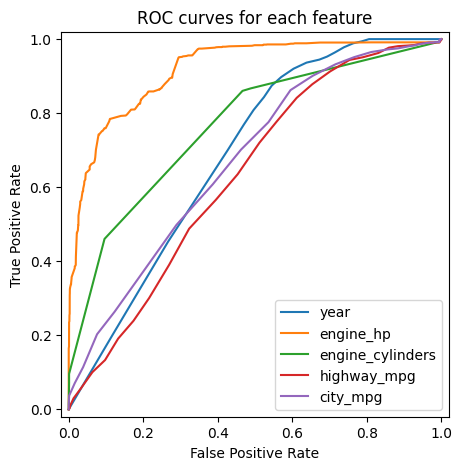

,Feature,AUC
1,engine_hp,0.92
2,engine_cylinders,0.77
0,year,0.69
4,city_mpg,0.67
3,highway_mpg,0.63


In [26]:
# Numerical features
mask = df.dtypes != object
numerical = list(df_train.dtypes[mask].index)


plt.figure(figsize=(5, 5))

# For each numerical feature, compute its importance and plot its ROC curve.
auc_dic = {}
for feature in numerical:
    current_auc, fpr, tpr, _, _ = roc_prec_recall(df_train[feature], Y_train)
    auc_dic[feature] = round(current_auc,2)
    plt.plot(fpr, tpr, label=f'{feature}')

# Setting the plot legend, limits, labels, and title.
plt.legend()
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for each feature')

plt.show()

# Convert the dictionary to a DataFrame
auc_df = pd.DataFrame(list(auc_dic.items()), columns=['Feature', 'AUC'])\
                                .sort_values(by='AUC', ascending=False)

display(auc_df)

<span style="color: #AC1555; font-weight: bold; font-size: 18px;">Question 2:</span>

Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

0.678
0.779
0.878
0.979

In [27]:
train_dict = df_train.to_dict(orient = 'records')
val_dict = df_val.to_dict(orient = 'records')

# One-hot encode
dv = DictVectorizer(sparse = False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear',C = 1.0, max_iter=1000)
model.fit(X_train, Y_train)

# get predicted probabilities for the positive class
Y_pred_proba = model.predict_proba(X_val)[:, 1]

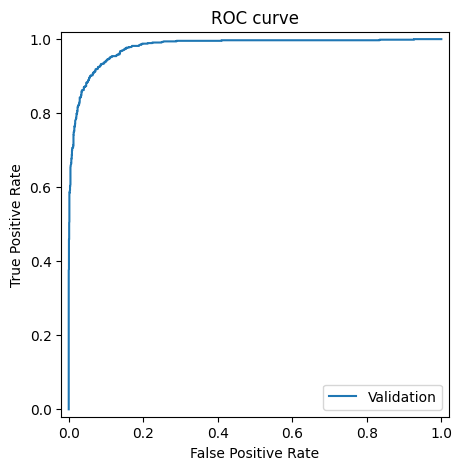

AUC = 0.979


In [28]:
plt.figure(figsize=(5, 5))
auc_value, fpr,tpr, __,_ = roc_prec_recall(Y_pred_proba, Y_val, feature_selection=False)
plt.plot(fpr, tpr, label=f'Validation')

# Settings
plt.legend()
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.show()

print('AUC =', round(auc_value, 3) )

<span style="color: #AC1555; font-weight: bold; font-size: 18px;">Question 3:</span>

Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

0.28
0.48
0.68
0.88

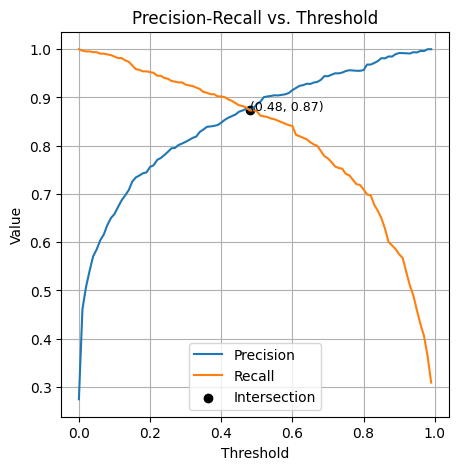

In [29]:
# Compute precision and recall using your function
thresholds = np.arange(0.0, 1.0 ,0.01)
_, _,_, precision, recall = roc_prec_recall(Y_pred_proba, Y_val, thresholds, feature_selection = False)

# Intersection point between precision and recall
intersect_point = np.abs(np.array(precision) - np.array(recall))
idx = np.argmin(intersect_point)
intersect_threshold =  thresholds[idx]
intersect_recall = recall[idx]

plt.figure(figsize=(5, 5))
_, _,_, precision, recall = roc_prec_recall(Y_pred_proba, Y_val, thresholds, feature_selection = False)
plt.plot(thresholds, precision, label=f'Precision')
plt.plot(thresholds, recall, label=f'Recall')
plt.scatter(intersect_threshold,intersect_recall, color = 'black', label='Intersection')
plt.text(intersect_threshold, intersect_recall, f'({intersect_threshold:.2f}, {intersect_recall:.2f})', color = 'black', fontsize=9)

# Settings
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Precision-Recall vs. Threshold')
plt.grid(True)
plt.show()

<span style="color: #AC1555; font-weight: bold; font-size: 18px;">Question 4:</span>

F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

 

Where 
 is precision and 
 is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

0.12
0.32
0.52
0.72



In [30]:
# Compute precision and recall using your function
thresholds = np.arange(0.0, 1.0, 0.01)
_, _, _, precision, recall = roc_prec_recall(Y_pred_proba, Y_val, thresholds, feature_selection=False)

# Compute F1 scores
precision = np.array(precision)
recall = np.array(recall)
F1 = 2 * (precision * recall) / (precision + recall)

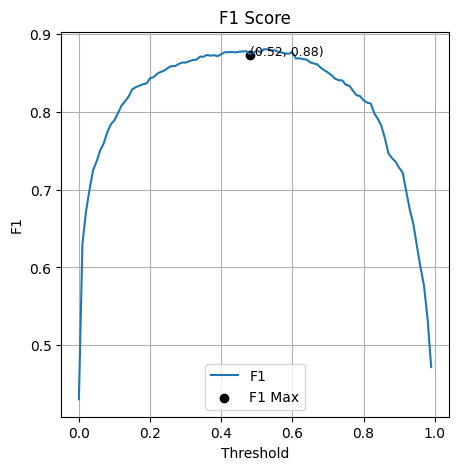

In [31]:
# Compute precision and recall using your function
thresholds = np.arange(0.0, 1.0, 0.01)
_, _, _, precision, recall = roc_prec_recall(Y_pred_proba, Y_val, thresholds, feature_selection=False)

# Compute F1 scores
precision = np.array(precision)
recall = np.array(recall)
F1 = 2 * (precision * recall) / (precision + recall)

# F1 maximum
idx = np.argmax(F1)
max_threshold = thresholds[idx]
max_f1 = F1[idx]

plt.figure(figsize=(5, 5))
plt.plot(thresholds, F1, label=f'F1')
plt.scatter(intersect_threshold,intersect_recall, color = 'black', label='F1 Max')
plt.text(intersect_threshold, intersect_recall, f'({max_threshold:.2f}, {max_f1:.2f})', color = 'black', fontsize=9)

# Settings
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('F1')
plt.title('F1 Score')
plt.grid(True)
plt.show()

<span style="color: #AC1555; font-weight: bold; font-size: 18px;">Question 5:</span>

5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard devidation of the scores across different folds?

0.003
0.030
0.090
0.140

In [32]:
def train(df, y, drop_feature = None):


    if drop_feature is not None:
        df = df.drop(columns=[drop_feature])
    df_dict = df.to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(df_dict)

    x_train = dv.transform(df_dict)

    model = LogisticRegression(solver='liblinear', C = 1.0, max_iter= 1000)
    model.fit(x_train, y)

    return dv, model


def predict(df, dv, model):
    df_dict = df.to_dict(orient='records')
    
    X = dv.transform(df_dict)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [33]:
kfold = KFold(n_splits = 5 , shuffle = True)

aucs = []
for train_idx, val_idx in kfold.split(df_full_train):

    # Split data in train and validation
    df_train = df_full_train.iloc[train_idx]
    Y_train = df_train['above_avg'].values

    df_val = df_full_train.iloc[val_idx]
    Y_val = df_val['above_avg'].values

    # train on train set and predict model on validation
    dv, model = train(df_train, Y_train, drop_feature = 'above_avg')
    Y_pred_proba = predict(df_val, dv, model) 

    # compute the AUC score and store it in the list
    auc_value, _, _, _, _ = roc_prec_recall(Y_pred_proba, Y_val, feature_selection= False) 
    aucs.append(auc_value)


# AUC for each fold
print('AUC folders:\n',np.array(aucs).round(3))

# Mean and standard deviation of AUCs across all folds
print('AUC stats = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

AUC folders:
 [0.981 0.975 0.98  0.984 0.973]
AUC stats = 0.978 ± 0.004


<span style="color: #AC1555; font-weight: bold; font-size: 18px;">Question 6:</span>

Hyperparemeter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.01, 0.1, 0.5, 10]
Initialize KFold with the same parameters as previously
Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

0.01
0.1
0.5
10
If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [34]:
kfold = KFold(n_splits = 5 , shuffle = True)

for C in [0.01, 0.1, 0.5, 10]:
    aucs = []
    for train_idx, val_idx in kfold.split(df_full_train):

        # Split data in train and validation
        df_train = df_full_train.iloc[train_idx]
        Y_train = df_train['above_avg'].values

        df_val = df_full_train.iloc[val_idx]
        Y_val = df_val['above_avg'].values

        # train on train set and predict model on validation
        dv, model = train(df_train, Y_train, drop_feature = 'above_avg')
        Y_pred_proba = predict(df_val, dv, model) 

        # compute the AUC score and store it in the list
        auc_value, _, _, _, _ = roc_prec_recall(Y_pred_proba, Y_val, feature_selection= False) 
        aucs.append(auc_value)
    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=0.01, auc = 0.981 ± 0.003
C=0.1, auc = 0.978 ± 0.003
C=0.5, auc = 0.979 ± 0.003
C=10, auc = 0.977 ± 0.007
